In [1]:
%matplotlib inline
import numpy as np
import scipy.linalg as la
import SimInterface.functionApproximator as fa
import numpy.random as rnd
import matplotlib.pyplot as plt
import sympy as sym
import SimInterface.utils.sympy_utils as su
import SimInterface.utils.numpy_utils as nu

First, we'll test our quadratic approximators.

Generate a random symmetric matrix and look at the corresponding cost

In [2]:
n = 10
B = fa.stackedSymmetricBasis(n+1)
quadApprox = fa.parameterizedQuadratic(NumVars=n)

In [3]:
C = rnd.randn(n+1,n+1)
C = C + C.T
x = rnd.randn(n)
z = np.hstack((1,x))

In [4]:
Cstacked = fa.stackLower(C)
CfullStack = np.dot(B,Cstacked)
quadApprox.resetParameter(Cstacked)
print C - np.reshape(CfullStack,(n+1,n+1),order='F')

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [5]:
TrueValue = np.dot(z,np.dot(C,z))

In [6]:
TrueValue - quadApprox.value(x)

0.0

In [7]:
quadApprox.parameterGradient(x) - np.dot(np.kron(z,z),B)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

Now, let's try an RBF parameterized 

In [8]:
reload(fa)

<module 'SimInterface.functionApproximator' from 'SimInterface/functionApproximator.pyc'>

In [9]:
Centers = np.array([np.linspace(-10,10,11)]).T
Lengths = .5
rbfApprox = fa.rbfNetwork(Centers=Centers,Lengths=Lengths)

X = np.linspace(-12,12,100)

In [10]:
rbfApprox.resetParameter(rnd.randn(rbfApprox.NumParams))

Y = np.zeros(len(X))

for k in range(len(X)):
    Y[k] = rbfApprox.value(X[k])
plt.plot(X,Y)

Finally, we'll test the more complex parameterized function:
\begin{equation*}
\log\mathcal{N}(u | \phi(x,k) \beta,CC^T) = 
-\frac{1}{2} (u-\phi(x,k)\beta)^T C^{-T} C^{-1} (u-\phi(x,k)\beta) 
- \log\det(C) - \frac{p}{2} \log(2\pi),
\end{equation*}
where $u\in\mathbb{R}^p$.

In [11]:
logGaussApprox = fa.parameterizedLogGaussian(basisFunction=fa.createRBFbasis(Centers,Lengths),NumU=1,NumX=1)

In [12]:
logGaussApprox.resetParameter(np.hstack((rnd.randn(len(Centers)),2)))

In [13]:
beta = logGaussApprox.parameter[:-1]
rbfApprox.resetParameter(beta)

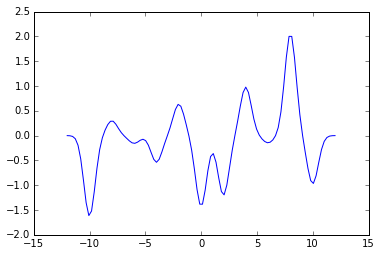

In [14]:
Y = np.zeros(len(X))

for k in range(len(X)):
    Y[k] = rbfApprox.value(X[k])
plt.plot(X,Y)

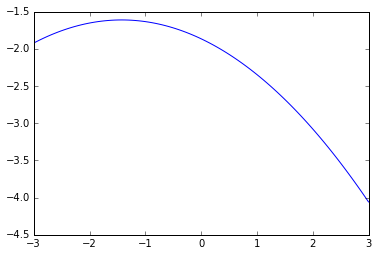

In [15]:
x = 0
U = np.linspace(-3,3,100)
Y = np.zeros(len(U))
for k in range(len(U)):
    u = U[k]
    z = np.hstack((x,u))
    Y[k] = logGaussApprox.value(z)
plt.plot(U,Y)

In [16]:
-np.log(2) - .5 * np.log(2*np.pi)

-1.6120857137646181

Now we'll try it with a two-dimensional example which we can compute analytically. 

In [17]:
def invertLower(A):
    if not isinstance(A,np.ndarray):
        return 1/A
    else:
        n = len(A)
    
    if n > 1:
        Atop = A[0,0]
        Aside = A[1:,0]
        Alow = A[1:,1:]
        AlowInv = invertLower(Alow)
        AinvTop = np.hstack((1/Atop,np.zeros(n-1,dtype=A.dtype)))
        AinvTop = nu.castToShape(AinvTop,(1,n))
        AinvSide = -np.dot(AlowInv,Aside)/Atop
        AinvSide = nu.castToShape(AinvSide,(n-1,1))
        
        Ainv = nu.stack(((AinvTop,),(AinvSide,AlowInv)))
    else:
        Ainv = 1/A
    return Ainv

In [18]:
def logDetTriangular(A):
    if not isinstance(A,np.ndarray):
        return A
    
    if A.dtype == np.dtype('float64'):
        return np.log(np.diag(A)).sum()
    
    n = len(A)
    
    ld = 0
    for k in range(n):
        ld += sym.log(A[k,k])
        
    return ld
        

In [19]:
p = 1 # Number of outputs, i.e. size of u
m = p*(p+1)/2 # number of non-zero coefficients of covariance cholesky
n = 5 # Number of inputs, i.e. size of x
q = 4 # Number of parameters
Cs = sym.symarray('Cs',m)
C = fa.unstackLower(Cs)
Cinv = invertLower(C)
logDet = logDetTriangular(C)
b = sym.symarray('b',q)

param = np.hstack((b,Cs))

In [20]:
x = rnd.randn(n)
bTrue = rnd.randn(q)
Sigma = rnd.randn(p,p)
Sigma = np.dot(Sigma,Sigma.T)
CTrue = la.cholesky(Sigma,lower=True)
CsTrue = fa.stackLower(CTrue)
paramTrue = np.hstack((bTrue,CsTrue))

Centers = rnd.randn(q,n)
Lengths = rnd.randn(q)
V = rnd.randn(p,q)
rbfBasis = fa.createRBFbasis(Centers,Lengths,V)
B = rbfBasis(x)

u = np.dot(B,bTrue) + np.dot(CTrue,rnd.randn(p))

logGaussApproximator = fa.parameterizedLogGaussian(basisFunction=rbfBasis,NumU=p,NumX=n)

logGaussApproximator.resetParameter(paramTrue)
# From the module
z = np.hstack((x,u))
valueTest = logGaussApproximator.value(z)
gradTest = logGaussApproximator.parameterGradient(z)

r = u - np.dot(B,b)
y = np.dot(Cinv,r)
# Simplify is REAL slow, but necessary 
quadPart = -.5 * np.dot(y,y)
detPart = -logDet 
constPart = -(p/2.) * np.log(2*np.pi)
value = quadPart + detPart - (p/2.) * np.log(2*np.pi)
valueJac = su.jacobian(value,param)

# Symbolocally computed value and jacobian
valueFun = su.functify(value,param)
quadPartFun = su.functify(quadPart,param)
detPartFun = su.functify(detPart,param)

valueJacFun = su.functify(valueJac,param)

valueSym = valueFun(paramTrue)
quadPartSym = quadPartFun(paramTrue)
detPartSym = detPartFun(paramTrue)

valueJacSym = valueJacFun(paramTrue)

# Test
print quadPartSym, detPartSym, constPart
print valueJacSym - gradTest

-0.178895632647 1.56553878145 -0.918938533205
[ -6.10321950e+02   1.46775278e-04   2.22057718e+15   3.19666394e+00
   1.47135444e+00]


In [21]:
logDetTriangular(CTrue)

-1.5655387814487174

In [22]:
su.simplify(Cinv)

array([[1/Cs_0]], dtype=object)

In [23]:
Cinv

array([[1/Cs_0]], dtype=object)